In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
%matplotlib inline

## functions

In [2]:
def K(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [3]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = K(xx,sigma_dict['C'])
    KH = K(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(1,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])*dt
        output[i+1,:] = (output[i,:]+dyj)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

In [4]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

## Main

In [5]:
sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*2/3# RF size of cone cell
dx = 0.01*sigma_dict['H']
 
dt=0.01
sigma_dict['tau_y'] = 0.02

In [6]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [7]:
#Width setting
xlen = 20*sigma_dict['H'] #spatial extend of simulation
hw = 0.75*sigma_dict['H']#half bar width
tempx = np.arange(0,xlen,dx)

In [8]:
para_dict = {}
para_dict['alpha'] = 1/0.024
para_dict['beta'] = 1./1.
para_dict['k'] = para_dict['alpha']*0.5
para_dict['phi'] = 1.
para_dict['g'] = para_dict['beta']

para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

0.5

In [9]:
loadfiles = np.load('STkernels.npz')

In [10]:
ST_kernel = loadfiles['arr_0']
# time = loadfiles['time_axis']

In [11]:
#main
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma=4.5
Omega =Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [12]:
LPOU_bar = np.zeros([len(T), int(xlen/dx)])
pos = 0
v = 0.5 #dx/step
hw = 10 #dx
speak = (LPOU-min(LPOU))/(max(LPOU)-min(LPOU))*800+600
for i in range(len(T)):
    pos = speak[i]
    LPOU_bar[i,max(int(pos-hw), 0):min(int(pos+hw), int(xlen/dx))] = 1

In [13]:
LPOU_y, zts, rpeak = Retina_Mechine_1D(LPOU_bar, sigma_dict, para_dict, dx, dt)

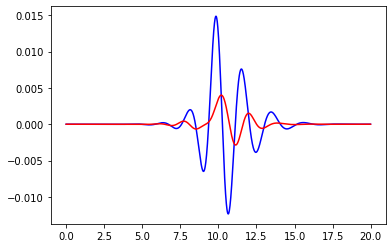

In [14]:
#####PLot numerical solution########
plt.plot(tempx,LPOU_y.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution

In [15]:
#assign states
x = speak.copy()
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
v = ndimage.gaussian_filter1d(x.copy(), sigma=1, order=1, mode='wrap') / dt
xstate, _= EqualState(x, 6)
vstate, _= EqualState(v, 6)
rstate, _= EqualState(rpeak, 6)

In [16]:
window = [-1,1] # second
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered i

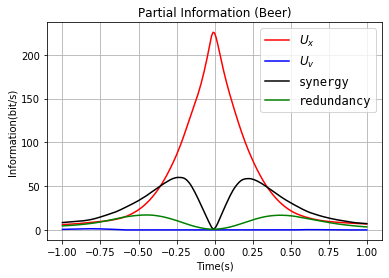

In [17]:
plt.plot(timeshift,Information[('Beer','UIx')], 'r-')
plt.plot(timeshift,Information[('Beer','UIv')], 'b-')
plt.plot(timeshift,Information[('Beer','Syn')], 'k-')
plt.plot(timeshift,Information[('Beer','Red')], 'g-')
plt.title('Partial Information (Beer)')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.grid()

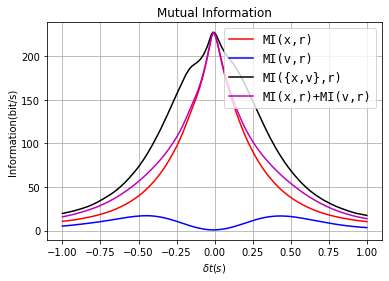

In [18]:
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]

#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel(r'$\delta t(s)$')
plt.ylabel('Information(bit/s)')
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.grid()

In [19]:
tic = toc.time()
STK_y = np.zeros([len(T), int(xlen/dx)])
for i in range(len(T)):
    for ii in np.arange(max(i-np.shape(ST_kernel)[0]+1, 0), i+1):
        STK_y[i,:] += np.convolve(LPOU_bar[ii,:],ST_kernel[i-ii, :], 'same')
toc.time()-tic

342.2469244003296

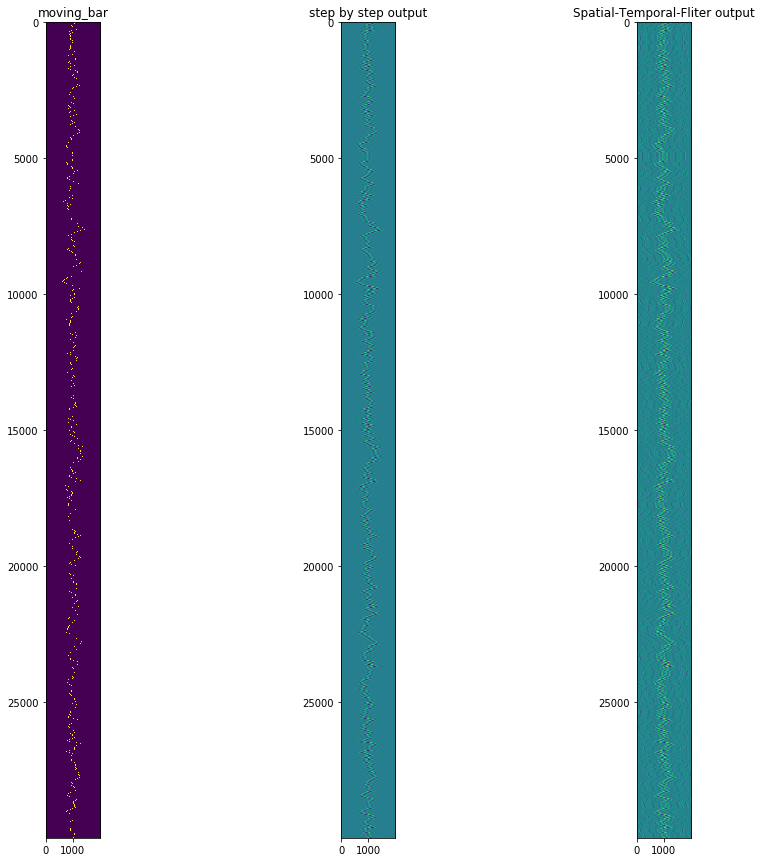

In [20]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(LPOU_bar)
ax2.set_title('moving_bar')
ax3.imshow(LPOU_y)
ax3.set_title('step by step output')
ax4.imshow(STK_y)
ax4.set_title('Spatial-Temporal-Fliter output')
fig.set_size_inches(15, 15)

In [21]:
STrpeak = np.zeros_like(rpeak)
for i in range(STK_y.shape[0]):
    STrpeak[i] = np.argmax(STK_y[i,:])

In [22]:
STrstate, _= EqualState(STrpeak, 6)

In [23]:
window = [-1,1] # second
timeshift, Information = PIfunc(STrstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered i

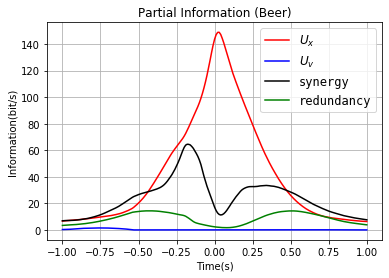

In [24]:
plt.plot(timeshift,Information[('Beer','UIx')], 'r-')
plt.plot(timeshift,Information[('Beer','UIv')], 'b-')
plt.plot(timeshift,Information[('Beer','Syn')], 'k-')
plt.plot(timeshift,Information[('Beer','Red')], 'g-')
plt.title('Partial Information (Beer)')
plt.xlabel('Time(s)')
plt.ylabel('Information(bit/s)')
plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.grid()

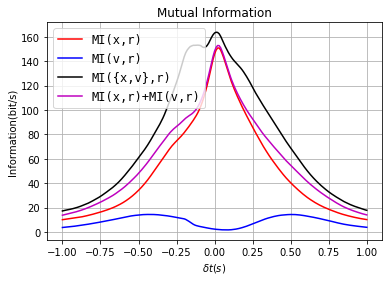

In [25]:
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]

#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')
plt.title('Mutual Information')
plt.xlabel(r'$\delta t(s)$')
plt.ylabel('Information(bit/s)')
plt.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.grid()